# Sea ice visualisations

---

Example visualising NOAA NSIDC sea ice satellite data on a 3D earth model using full Blue Marble NASA imagery with GEBCO topography


### Data sources:

National Snow and Ice Data Center

- https://noaadata.apps.nsidc.org/
- https://nsidc.org/data/user-resources/help-center/how-access-and-download-noaansidc-data
- https://nsidc.org/about/data-use-and-copyright

Historical Antarctic daily satellite data
( NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4 )
Data set id: G02202
DOI: 10.7265/efmz-2t65
- https://noaadata.apps.nsidc.org/NOAA/G02202_V4/south/daily/1978/ (-2023)
- https://nsidc.org/data/g02202/versions/4

    Meier, W. N., F. Fetterer, A. K. Windnagel, and J. S. Stewart. (2021). NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4 [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/efmz-2t65. Date Accessed 02-19-2024.

Current year Antarctic daily satellite data
( Near-Real-Time NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 2 )
Data set id: G10016
DOI: 10.7265/tgam-yv28
- https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2023/
- https://nsidc.org/data/g10016/versions/2

    Meier, W. N., F. Fetterer, A. K. Windnagel, and J. S. Stewart. (2021). Near-Real-Time NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 2 [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/tgam-yv28. Date Accessed 02-19-2024.

#### Earth satellite imagery and ocean/water masks
- https://earthobservatory.nasa.gov/features/BlueMarble

#### Topography:
- https://visibleearth.nasa.gov/images/73934/topography
- https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73934/gebco_08_rev_elev_21600x10800.png

#### Bathymetry
- https://visibleearth.nasa.gov/images/73963/bathymetry
- https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73963/gebco_08_rev_bath_21600x10800.png

#### Textures and misc resources
https://www.manytextures.com/texture/23/sea-water/ Sea water by ManyTextures.com is licensed under a Creative Commons Attribution 4.0 International License. https://creativecommons.org/licenses/by/4.0/

In [1]:
try:
    import sys
    import os
    import numpy as np
    import xarray as xr
    import datetime
    import calendar
    from dateutil.relativedelta import relativedelta
    import scipy.interpolate
    import matplotlib
    import matplotlib.pyplot as plt
    import cmocean
    from PIL import Image
    import subprocess
    import accessvis

    import json
    import glob
    from pathlib import Path
    from scipy import spatial
    import scipy.ndimage
    import lavavu
    from lavavu import convert

    import quaternion as quat
    import math

    from shapelysmooth import catmull_rom_smooth
    import itertools
    from scipy import spatial


except (ImportError) as e:
    print('ImportError: Installing dependencies, please run this cell again...')
    !pip install xarray scipy cmocean h5netcdf dask netCDF4 py360convert numpy-quaternion shapelysmooth pillow lavavu numpy-quaternion tqdm dask[distributed]
    raise('Installed dependencies, please run this cell again')

In [2]:
#Settings

hemisphere = 'south'
#hemisphere = 'north'

accessvis.resolution_selection(default=3)

Low-res 2K - fast for testing
Mid-res 4K - good enough for full earth views
High res 8K - better if showing close up at country scale
Ultra-high 16K - max detail but requires a fast GPU with high memory


Dropdown(description='Detail:', index=2, options=(('Low-res 2K', 1), ('Mid-res 4K', 2), ('High-res 8K', 3), ('…

In [3]:
#!pip install dask[distributed]

# load data

NOAA/NSIDC Climate Data Record of Passive
Microwave Sea Ice Concentration, Version 4

https://nsidc.org/sites/default/files/g02202-v004-userguide_1_1.pdf

https://nsidc.org/data/g02202/versions/4

https://noaadata.apps.nsidc.org/NOAA/G02202_V4/south/daily/2023/

https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2023/ ??

In [4]:
#https://noaadata.apps.nsidc.org/NOAA/G02202_V4/south/daily/2023/\
H = hemisphere[0].lower() + 'h'

#All years data
fn = f'seaice_conc_daily_{H}_*.nc'
base_dir = '/g/data/xp65/public/apps/access-vis-data/'
#base_dir = '/media/data/'

#Cached on gadi
datadir = f'{base_dir}noaadata.apps.nsidc.org/NOAA/G02202_V4/{hemisphere}/aggregate/'

print(datadir)
#download files if not existing
cmd = f"wget -nc -e robots=off --recursive --no-parent https://noaadata.apps.nsidc.org/NOAA/G02202_V4/{hemisphere}/aggregate/"
p = subprocess.Popen(cmd.split(), cwd=base_dir)
p.wait()

/media/data/noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/


File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/index.html’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1978_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1979_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1980_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1981_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1982_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1983_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1984_v04r00.nc’ already there; no

0

In [5]:

#Open the dataset
ds_sea_ice = xr.open_mfdataset(datadir + fn, combine='nested', concat_dim='tdim')
ds_sea_ice

<xarray.Dataset> Size: 62GB
Dimensions:                      (tdim: 16320, y: 332, x: 316)
Coordinates:
    time                         (tdim) datetime64[ns] 131kB dask.array<chunksize=(68,), meta=np.ndarray>
    xgrid                        (x) float32 1kB dask.array<chunksize=(316,), meta=np.ndarray>
    ygrid                        (y) float32 1kB dask.array<chunksize=(332,), meta=np.ndarray>
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc              (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_bt_seaice_conc         (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_nt_seaice_conc         (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    projection                   (tdim) |S1 16kB b'' b'' b'' b'' ... b'' b'' b''
    qa_of_cdr_seaice_conc        (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    spatial_interpolation_flag   (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    stdev_of_cdr_seaice_conc     (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    temporal_interpolation_flag  (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    latitude                     (tdim, y, x) float32 7GB dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    longitude                    (tdim, y, x) float32 7GB dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-21T21:22:35Z
    time_coverage_start:       1978-10-25T00:00:00Z
    time_coverage_end:         1978-12-31T23:59:59Z

In [6]:
#https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2023/

#datadir = base_dir + 'daily_NRT/'
#ds_sea_ice_NRT = xr.open_mfdataset(datadir + '202?/*.nc', 
#                              combine='nested', concat_dim='tdim')

#First 6 months are in aggregate file, rest in daily files
#wget -nc https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/aggregate/seaice_conc_daily_sh_2023_v04r00.nc
year = datetime.datetime.now().year

#Get/update all daily NRT data for current year
subdir = f'noaadata.apps.nsidc.org/NOAA/G10016_V2/{hemisphere}/daily/'
#path = Path(dir)
#path.mkdir(parents=True, exist_ok=True)

#To get latest, need to delete index.html first, then re-run wget
#This doesn't work with variables, need to use python functions and lv.download
ifn = f"{base_dir + subdir}{year}/index.html"
if os.path.exists(ifn):
    os.remove(ifn)
#cmd = "wget -nc -e robots=off --recursive --no-parent https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2023/"
cmd = f"wget -nc -e robots=off --recursive --no-parent https://noaadata.apps.nsidc.org/NOAA/G10016_V2/{hemisphere}/daily/2024/"
p = subprocess.Popen(cmd.split(), cwd=base_dir)
p.wait()

--2024-12-06 11:41:31--  https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/
Resolving noaadata.apps.nsidc.org (noaadata.apps.nsidc.org)... 128.138.135.43
Connecting to noaadata.apps.nsidc.org (noaadata.apps.nsidc.org)|128.138.135.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/index.html’

     0K .......... .......... .......... ......                 174K=0.2s

2024-12-06 11:41:32 (174 KB/s) - ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/index.html’ saved [37531]

File ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/seaice_conc_daily_icdr_sh_20240401_f18_v02r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/seaice_conc_daily_icdr_sh_20240402_f18_v02r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/seaice_conc_daily_icdr_sh_202404

0

In [7]:
lyear = year - 1 #Last year
aggregate = [f'{datadir}seaice_conc_daily_{H}_{lyear}_v04r00.nc']
dailyfiles_24 = sorted(glob.glob(f'{base_dir + subdir}2024/seaice_conc_daily_icdr_{H}_2024*_f18_v02r00.nc'))
files = aggregate + dailyfiles_24
#files = dailyfiles

ds_sea_ice_NRT = xr.open_mfdataset(files, combine='nested', concat_dim='tdim')

In [8]:
ds_sea_ice_NRT

<xarray.Dataset> Size: 2GB
Dimensions:                      (tdim: 516, y: 332, x: 316)
Coordinates:
    time                         (tdim) datetime64[ns] 4kB dask.array<chunksize=(181,), meta=np.ndarray>
    xgrid                        (x) float32 1kB dask.array<chunksize=(316,), meta=np.ndarray>
    ygrid                        (y) float32 1kB dask.array<chunksize=(332,), meta=np.ndarray>
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc              (tdim, y, x) float32 217MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_bt_seaice_conc         (tdim, y, x) float32 217MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_nt_seaice_conc         (tdim, y, x) float32 217MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    projection                   (tdim) |S1 516B b'' b'' b'' b'' ... b'' b'' b''
    qa_of_cdr_seaice_conc        (tdim, y, x) float32 217MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    spatial_interpolation_flag   (tdim, y, x) float32 217MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    stdev_of_cdr_seaice_conc     (tdim, y, x) float32 217MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    temporal_interpolation_flag  (tdim, y, x) float32 217MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    latitude                     (tdim, y, x) float32 217MB dask.array<chunksize=(516, 332, 316), meta=np.ndarray>
    longitude                    (tdim, y, x) float32 217MB dask.array<chunksize=(516, 332, 316), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2023-09-26T20:17:19Z
    time_coverage_start:       2023-01-01T00:00:00Z
    time_coverage_end:         2023-06-30T23:59:59Z

In [9]:
STEPS = ds_sea_ice_NRT['cdr_seaice_conc'].shape[0]
print(STEPS)

516


In [10]:
#tdim,y,x : Shape 	(181, 332, 316)
#lon:-180,180
#lat:-90:90
print('Extents:')
latitude = np.array(ds_sea_ice['latitude'].sel(tdim=0))
longitude = np.array(ds_sea_ice['longitude'].sel(tdim=0))
print(latitude[0][0], longitude[0][0])
print(latitude[-1][-1], longitude[-1][-1])
#print('-45,45.....')
#print(latitude[42][0], longitude[42][0])
#print(latitude[-27][-1], longitude[-27][-1])

#https://nsidc.org/data/g02202/versions/4
#Spatial Resolution:
#25 km
#NSIDC Sea Ice Polar Stereographic South EPSG:3412
#Spatial Coverage: N:-39.36 S:-89.84 E:180 W: -180
#N: 89.84 S: 31.1 E: 180 W: -180
#dat = ds_sea_ice_clim.sel(dayofyear=50) #, x=slice(0,316), y=slice(0,332))
#dat = ds_sea_ice_clim.sel(dayofyear=50)

Extents:
-39.36487 -42.23257
-41.58345 135.0


In [11]:
#Save dates list
dates = np.array(ds_sea_ice['time']).astype('datetime64[D]')
dates_NRT = np.array(ds_sea_ice_NRT['time']).astype('datetime64[D]')


# Season/month widget

[0.         1.57079633 3.14159265 4.71238898]
4


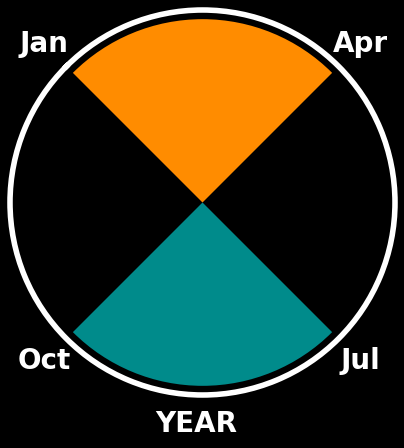

In [12]:
### Current date widget

#Dark
plt.style.use("dark_background")
#Thicker lines, larger fonts
plt.rc('axes', linewidth=4)
plt.rc('font', weight='bold')

# Add bars in polar coordinates
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5,5))
fig.suptitle('YEAR', fontsize=20, fontweight='bold', y=0.08)

#Set transparent background
ax.patch.set_facecolor('black')
ax.patch.set_alpha(0.0)

ax.set_rticks([])  # Remove radial ticks
ax.grid(False)

ax.set_theta_zero_location('NW')
ax.set_theta_direction(-1)

plt.bar(x=5*np.pi/4, height=10, width=np.pi/2, color='darkcyan' if hemisphere == 'south' else 'darkorange'); #Southern Winter
plt.bar(x=np.pi/4, height=10, width=np.pi/2, color='darkorange' if hemisphere == 'south' else 'darkcyan');   #Southern Summer

# Add month vertical lines. These are just references
#ANGLES = np.linspace(0.0, 2 * np.pi, 12, endpoint=False)
#ax.vlines(ANGLES, 0, 10, color='#cccccc', zorder=11)

# Add labels for the months
#MONTH = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#MONTH = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
MONTH = ['Jan', 'Apr', 'Jul', 'Oct']

ANGLES = np.linspace(0.0, 2 * np.pi, 4, endpoint=False)
print(ANGLES)
print(len(ANGLES))

#Space the labels out further
ax.tick_params(axis='x', which='major', pad=12)

# Set the labels
ax.set_xticks(ANGLES)
ax.set_xticklabels(MONTH, size=20);

arr = None #ax.arrow(0, 0, 0, 10, facecolor='#fff', width=0.1, head_length=2, edgecolor="black") #, zorder=11, width=1)
canvas = fig.canvas

def plot_date(a_date=None, data_date=None):
    global arr, canvas, ax, fig
    try:
        arr.remove()
    except:
        pass

    #Add the current date line
    if a_date is not None:
        title = str(a_date.year)
        if data_date is not None:
            title = f"{a_date.year} / {data_date.year}"
        fig.suptitle(title, fontsize=20, fontweight='bold', y=0.08)
    
        #ax.vlines([POS], 0, 10, color='#fff', zorder=11, linewidth=10)
        day_of_year = a_date.timetuple().tm_yday - 1 #Day of year [0-365]
        POS = day_of_year / 365. * np.pi * 2.0
        arr = ax.arrow(POS, 0, 0, 10, facecolor='#fff', width=0.1, head_length=2, edgecolor="black") #, zorder=11, width=1)

    canvas.draw()  # Draw the canvas, cache the renderer
    pixels = np.asarray(canvas.buffer_rgba())
    #Replace background with transparent
    pixels[:, :, 3] = (255 * (pixels[:, :, :3] != 0).any(axis=2)).astype(np.uint8)
    return pixels

# 3d plot of sea ice

In [13]:
def get_data_at(date):
    #Find timestep index and dataset for given date
    if date.year >= 2023:
        if date > dates_NRT[-1]:
            return None
        #2023 (using data up to day 309 - 5/11/2023)
        #T = date.timetuple().tm_yday - 1 #Day of year [0-365]
        #ts = dates_NRT[T]
        itemindex = np.where(dates_NRT == date)
        T = itemindex[0]
        ts = dates_NRT[T]
        assert(ts == date)
        dat = ds_sea_ice_NRT.sel(tdim=T)
    else:
        itemindex = np.where(dates == date)
        T = itemindex[0]
        ts = dates[T] #.item() #.astype(datetime.datetime)
        assert(ts == date)
        dat = ds_sea_ice.sel(tdim=T)
    return dat

def get_grid():
    #Just get the raw grid points
    altitudes = np.zeros_like(latitude) + 0.0005 #Raise the sea ice slightly above sea level (0.001 = 1 Metre)
    arrays = accessvis.latlon_to_3D(latitude, longitude, altitudes)
    V = np.dstack(arrays)
    print(V.shape)
    return V

def get_ice_data_at(date):
    dat = get_data_at(date)
    if dat is None:
        return dat
    dat = dat['cdr_seaice_conc']
    #m = dat.where(dat>1)
    #mask = np.array(m) > 1
    dat = dat.where(dat>0)
    #dat = dat.where(dat<=1) #Clears mask
    data = np.array(dat)[0]
    #print(data.shape)
    
    #Land mask > 1.0
    #data[mask] = data.max() #Land mask - replace with max ice value

    if hemisphere == 'south':
        #Want to keep land max = 1.0 for antarctica, but clear islands
        #Clear tierra del fuego and nearby islands
        data[0:140,0:20] = 0.
    
        #Replace land with max ice
        data[data > 1.0] = 1.0
    else:
        #Replace land with max ice
        data[data > 1.0] = 0.0
    
    #Replace NaN with 0.0
    data[np.isnan(data)] = 0.0

    return data
   
def get_ice_data_at_orig(date):
    dat = get_data_at(date)
    dat = dat['cdr_seaice_conc'].where(dat['cdr_seaice_conc']<=1)
    dat = dat.where(dat>0)
    data = np.array(dat)
    data[np.isnan(data)] = 0.0
    return data[0]



# 3D model setup

In [14]:
#Get mesh grid
mesh = get_grid()

(332, 316, 3)


### Create ocean surface level mesh to plot Sea Ice

In [15]:
#Get a data sample at given date
#a_date = datetime.strptime("2014-06-01 00:00:00", "%Y-%m-%d %H:%M:%S")
a_date = datetime.datetime.strptime("1980-06-01 00:00:00", "%Y-%m-%d %H:%M:%S")
D = get_ice_data_at(a_date.date())
#D = np.load('ice_values.npy')
mesh.shape, D.shape

((332, 316, 3), (332, 316))

In [16]:
D.min(), D.max(), D.shape

(0.0, 1.0, (332, 316))

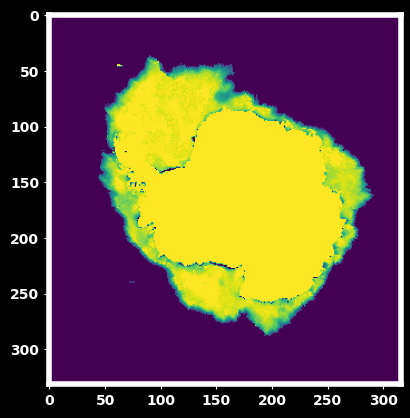

In [17]:
matplotlib.pyplot.imshow(D)

In [18]:
#Gets texture image from the sea ice data
def get_ice_image(D, mmin=None, mmax=None):
    #Normalise
    if mmin is not None and mmax is not None:
        image = (D-mmin)/(mmax-mmin)
        #Clip out of [0,1] range - in case defined range is not the global minima/maxima
        image = np.clip(image, 0, 1)
    else:
        image = D
    #Filter out < 0.1
    #image =  image * 0.91 #[image < 0.9] = 0.0
    #image[image < 0.1] = 0.0
    
    return np.uint8(image*255)

In [19]:
print(D.min(), D.max())
I = get_ice_image(D) #, D.min(), D.max())
print(I.min(), I.max())

0.0 1.0
0 255


In [20]:
mesh.shape

(332, 316, 3)

In [21]:
#Upscale / zoom the mesh - creates a finer mesh
z = 2 #3
mesh = scipy.ndimage.zoom(mesh, [z,z,1], order=3)
mesh.shape

(664, 632, 3)

In [22]:
# CREATE VIEWER

#lv = lavavu.Viewer(background='#222222', border=False, axis=False, resolution=(1920//2,1080//2))
lv = lavavu.Viewer(background='#222222', border=False, axis=False, resolution=(1920,1080))

In [23]:
radius = 6371 * 1e-3 #Radius in Mm
#Manual bounding box
x=radius
lv["min"] = [-x,-x,-x]
lv["max"] = [x,x,x]

#lv.addstep(0) #Add a timestep or things don't work on load

#Use texture
#tris0 = lv.surface("sea_ice", vertices=mesh, fliptexture=False, renderer='sortedtriangles', colourmap=colours) #colour='black:0')
#tris0['texture'] = 'seaice.png' #Need an initial texture or texcoords will not be generated

#Use texture - more flexible for up-scaling etc
I = get_ice_image(D)

#matplotlib.pyplot.imshow(I)
tris0 = lv.surface("sea_ice", renderer='sortedtriangles', ambient=0.9) #85) #, colour='black:0')
#tris0.vertices(mesh)
#tris0.texture(I, flip=False)

#Custom shaders for plotting the sea ice
tris0['shaders'] = ['triShader_ice.vert', 'triShader_ice.frag']


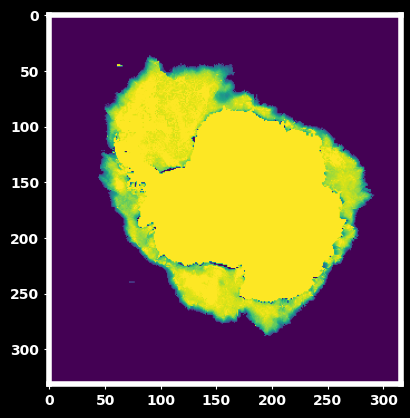

In [24]:
matplotlib.pyplot.imshow(I)
#I = get_ice_image(D)
#tris0.texture(I, flip=False)
#tris0.values(D) #.reshape((332, 316)))
#tris0.reload()

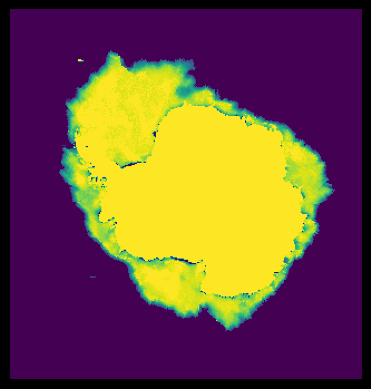

In [25]:
#plt.imshow(tas)
plt.imshow(I)
plt.axis('off')
fig.savefig('out.png', bbox_inches='tight', pad_inches=0)

#### Ice rendering tweaks - sea ice render with textures

In [26]:
#Custom textures / uniforms for sea ice
uniforms = {}
for i in range(10,101,10):
    t = f"ice{i}"
    uniforms[t] = t + '.png'
tris0['uniforms'] = uniforms
tris0['repeat'] = True
print(tris0)

{
  ambient=0.9
  name="sea_ice"
  renderer="sortedtriangles"
  repeat=true
  shaders=["triShader_ice.vert", "triShader_ice.frag"]
  uniforms={"ice10": "ice10.png", "ice100": "ice100.png", "ice20": "ice20.png", "ice30": "ice30.png", "ice40": "ice40.png", "ice50": "ice50.png", "ice60": "ice60.png", "ice70": "ice70.png", "ice80": "ice80.png", "ice90": "ice90.png"}
  visible=true
}



# Load earth topography model

In [27]:
import datetime
dt = datetime.datetime(2024, 1, 1, 12, 0, 0)
hemi = hemisphere[0].upper()
lv = accessvis.plot_earth(lv, waves=True, when=dt, blendtex=True, vertical_exaggeration=15, hemisphere=hemi)


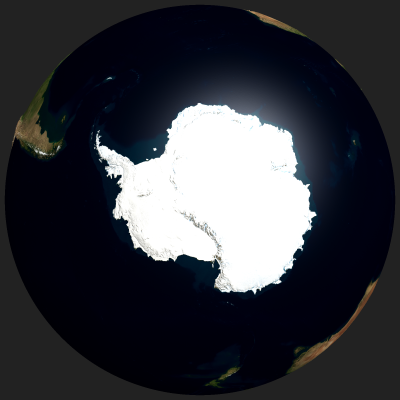

In [28]:
lv.translation(0.0, 0.0, -17)
#lv.rotation(0.0, -125.0, 0.0) #Australia view
#lv.rotation(0.0, 0.0, 0.0) #Prime meridian view
lv.display((400,400))

In [29]:
#Create the 2d overlay plot - problems updating texture here unless this is the last object added
overlay = lv.screen(shaders=['screen.vert', 'screen.frag'], vertices=[[0,0,0]], texture="blank.png")


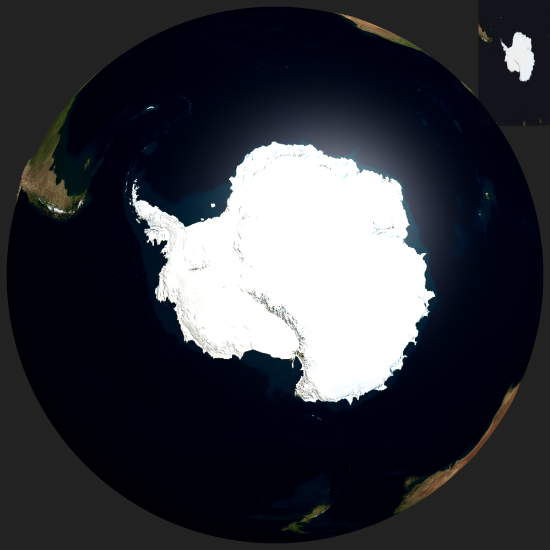

In [30]:
#lv.display((1000,563))
lv.display((550,550))


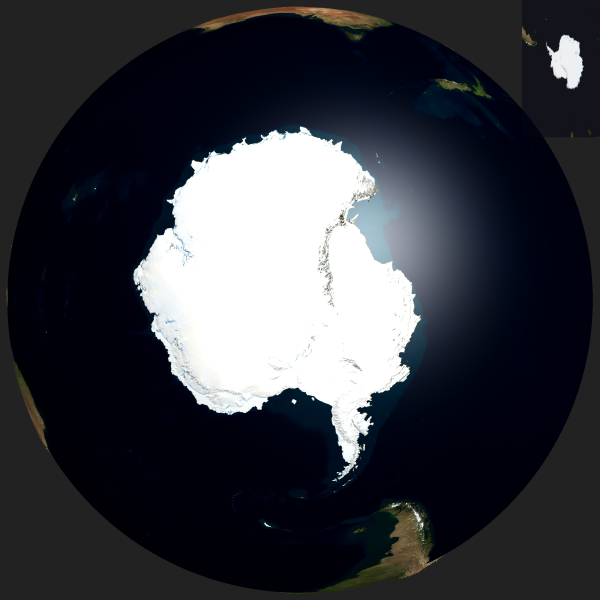

In [31]:
if hemisphere == 'south':
    lv.rotation(-90, 0, 135)
else:
    lv.rotation(90, 0, 0)
lv.display((600,600))

In [32]:
lv.camera();

lv.translation(0.0, 0.0, -17.0)
lv.rotation(-90.0, 0.0, 135.0)


### Lighting etc

In [33]:
#lv.set_properties(diffuse=0.5, ambient=0.5, specular=0.05, shininess=0.06, light=[1,1,0.98,1], lightpos=accessvis.sun_light())
#lv.set_properties(diffuse=0.6, ambient=0.6, specular=0.001, shininess=0.01, light=[1,1,0.98,1])
lv.set_properties(diffuse=1.0, ambient=0.7, specular=0.3, shininess=0.05, light=[1,1,0.98,1], lightpos=accessvis.sun_light(hour=12))



In [34]:
#Defaults
lv.brightness_contrast_saturation(0.55, 0.5, 0.6)

#Adjusted for sea ice plot
#lv["brightness"] = 0 #-0.02
#lv["contrast"] = 1.5 #1.2
#lv["saturation"] = 0.4 #0.3 #0.5

In [35]:
#Blank the overlay
#ts = datetime.date(1899, 3, 28)
plot = plot_date()
print(plot.shape)
plot[::,::,::] = 0

overlay.texture(plot) #Clear texture with transparent image

#lv.display((1000,563))

(500, 500, 4)


### Animate

In [36]:
#lv.interactive()

In [37]:
lv.camera();

lv.translation(0.0, 0.0, -17.0)
lv.rotation(-90.0, 0.0, 135.0)


In [38]:
lv.window(resolution=(1920//2, 1080//2))

# Top view sea ice history plot


In [43]:
# Overhead view for sea ice year animation plot
lv.resize(1080,1080)
lv.translation(0.0, 0.0, -16.75)
#lv.translation(0.0, 0.0, -14)
lv.rotation(-90.0, 0.0, 135.0)
if hemisphere == 'south':
    #lv.rotation(-90.0, 0.0, 0.0)
    lv.rotation(-90, 0, 135)
else:
    #lv.rotation(90, 0, -45)
    lv.rotation(90, 0, 0)
    #lv.rotation(90.0, 0.0, 135.0)

lv["background"] = 'black' #"#222222"

In [44]:
#lv.camera()

In [45]:
#Custom uniforms to pass size details to inset display
lv.set_uniforms('screen1', size=0.2, res=[1080, 1080])


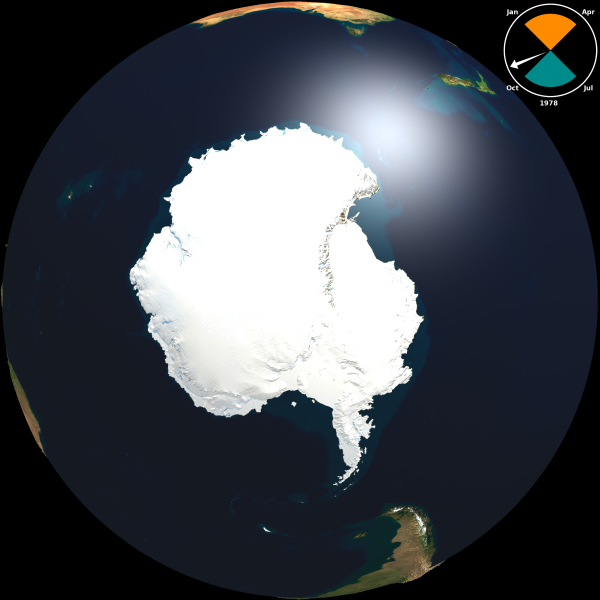

In [46]:
#Test overlay plot
ts = dates[0].item() #First record
Im = plot_date(ts)
overlay.texture(Im) #, flip=False)
lv.display((600,600))

In [47]:
#Use midday in brisbane time to avoid daylight savings issues
import pytz
tz=pytz.timezone("Australia/Brisbane")

def animate_history():
    global overlay
    start_date = dates[0].item() #First record
    #Just plot NRT data for testing
    #start_date = dates_NRT[0].item()
    end_date = dates_NRT[-1].item() #Last record of current year
    delta = datetime.timedelta(days=1)
    if len(tris0.data) == 0:
        tris0.vertices(mesh)
    y0 = start_date.year
    while start_date <= end_date:
        ts = start_date
        if ts.year != y0:
            print(ts.year)
            y0 = ts.year

        #Im = get_day_img(ts)
        Im = plot_date(ts)
            
        overlay.texture(Im) #, flip=False)

        #Use previous years data if none available for current date?
        D = get_ice_data_at(start_date)
        #tris0.vertices(mesh)
        I = get_ice_image(D)
        
        tris0.texture(I, flip=False)
        #tris0.reload()
        #tris0.values(D) #.reshape((332, 316)))
        #lv.reload()

        #Update sun position
        if hemisphere == 'north':
            #when = when.replace(tzinfo=datetime.timezone.utc)
            #Keep brisbane time as avoids daylight switch issues but convert to noon in Britain
            #Brisbane time = UTC+10, so 22:00 == UTC midday
            when = datetime.datetime(ts.year, ts.month, ts.day, 22, 0, 0, 0, tz)
        else:
            when = datetime.datetime(ts.year, ts.month, ts.day, 12, 0, 0, 0, tz)
        #lv.set_properties(lightpos=accessvis.sun_light(time=when))
        accessvis.update_earth_datetime(lv, when=when, sunlight=True)        
        
        lv.render()
        
        start_date += delta

In [ ]:
lv.title() #Clear title
#30x8 = 240 fps : 8*speed up ~ 1 min
with lv.video(filename=f'sea_ice_{hemisphere}_v10.mp4', fps=240, resolution=(1080,1080), width=1080//2, height=1080//2, params="autoplay"):
    animate_history()


In [ ]:
#Speed up ~6.67x (1/0.15)
#!ffmpeg -itsscale 0.15 -i sea_ice_v4.mp4 -c copy sea_ice_v4_fast.mp4

#Get frame count
#ffprobe -v error -select_streams v:0 -count_packets -show_entries stream=nb_read_packets -of csv=p=0 sea_ice_v4.mp4


## Combined north/south video

Info re:
The Constant Rate Factor (CRF) is the default quality (and rate control) setting for the x264 and x265 encoders, and it’s also available for libvpx. With x264 and x265, you can set the values between 0 and 51, where lower values would result in better quality, at the expense of higher file sizes. Higher values mean more compression, but at some point you will notice the quality degradation.

For x264, sane values are between 18 and 28. The default is 23, so you can use this as a starting point.

In [ ]:
#!ffmpeg -i sea_ice_south_v10.mp4 -i sea_ice_north_v10.mp4 -filter_complex "hstack,format=yuv420p" -c:v libx264 -crf 18 sea_ice_combined.mp4

In [ ]:
#!ffmpeg -i sea_ice_south_v10.mp4 -i sea_ice_north_v10.mp4 -filter_complex "hstack,format=yuv420p" -c:v libx264 -crf 28 sea_ice_combined_smaller.mp4 

In [ ]:
#Add Watermark
#!ffmpeg -y -i sea_ice_south_v10.mp4 -i ~/ACCESS-NRI/Logos/watermark_small_faded.png -filter_complex "overlay=10:600" sea_ice_south_v10_wm.mp4

In [ ]:
#!ffmpeg -y -i sea_ice_north_v10.mp4 -i ~/ACCESS-NRI/Logos/watermark_small_faded.png -filter_complex "overlay=10:600" sea_ice_north_v10_wm.mp4

In [ ]:
#!ffmpeg -y -i sea_ice_combined.mp4 -i ~/ACCESS-NRI/Logos/watermark_small_faded.png -filter_complex "overlay=600:600" sea_ice_combined_wm.mp4

In [ ]:
#!ffmpeg -y -i sea_ice_combined_smaller.mp4 -i ~/ACCESS-NRI/Logos/watermark_small_faded.png -filter_complex "overlay=600:600" sea_ice_combined_smaller_wm.mp4